In [ ]:
pip install web.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.2/623.2 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.2 MB/s eta 0:00:00
  Created wheel for web.py: filename=web_py-0.62-py3-none-any.whl size=78640 sha256=5b82c26f3374d509b450f8555f94b847e0841bf13fdb928cbac907f922b191da
  Stored in directory: /root/.cache/pip/wheels/ce/56/6e/0e399681158faaa4d3b15c5d095b0047357e1c727e6c3fd004
Successfully built web.py


In [ ]:
pip install tidy3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: h5netcdf
    Found existing installation: h5netcdf 1.6.1
    Uninstalling h5netcdf-1.6.1:
      Successfully uninstalled h5netcdf-1.6.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

In [ ]:
lda0 = 1.35  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.1, 1.6, 301)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency

In [ ]:
# define gold medium
au = td.Drude(eps_inf=9.0685, coeffs=[(135.44e14 / (2 * np.pi), 1.15e14 / (2 * np.pi))])

# define sio2 medium
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

# define air medium
air = td.Medium(permittivity=1)

In [ ]:
L = 0.6  # side length of the square cavity
g = 0.01  # gap size between the bus waveguide and the square cavity
W1 = 0.09  # width of the square cavity waveguide
W = 0.06  # width of the bus waveguide
H = 0.7  # thickness of the gold layer
inf_eff = 1e2  # effective infinity of the simulation
R_outer = L / 2  # Outer radius of the circular ring
R_inner = R_outer - W1

In [ ]:
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# define the gold layer structure on top of the substrate
au_layer = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, H)), medium=au
)

# define the air-filled bus waveguide structure
bus_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-W / 2, -inf_eff, 0), rmax=(W / 2, inf_eff, H)), medium=air
)

refine_structure = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-W / 2, -R_outer, 0),
        rmax=(W / 2 + g + 2 * R_outer, R_outer, H)
    ),
    medium=td.Medium(permittivity=20**2),
)

In [ ]:
buffer = lda0 / 2  # buffer length in each direction

# define simulation domain size
Lx = L + buffer
Ly = L + g + W + buffer
Lz = H + buffer

run_time = 1.5e-13  # simulation run time

# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=2)
mode_source = td.ModeSource(
    center=(0, -L / 2 - lda0 / 4, H / 2),
    size=(4 * W, 0, 3 * H),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=5,
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(0, L / 2 + lda0 / 4, H / 2),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add a field monitor to visualize field distribution at z=H/2
field_monitor = td.FieldMonitor(
    center=(0, 0, H / 2), size=(td.inf, td.inf, 0), freqs=[np.min(freqs), freq0], name="field"
)

In [ ]:
def make_sim(n_phmb):

    # define the phmb medium
    phmb = td.Medium(permittivity=n_phmb**2)

    # define the outer square cavity structure
    ring_cavity_outer = td.Structure(
    geometry=td.Cylinder(
        axis=2,  # z-direction
        center=(W / 2 + g + R_outer, 0, H / 2),
        radius=R_outer,
        length=H
    ),
    medium=phmb,
    )
    #extra_margin = 0.05
    ring_cavity_inner = td.Structure(
    geometry=td.Cylinder(
        axis=2,
        center=(W / 2 + g + R_outer, 0, H / 2),
        radius=R_inner,
        length=H
    ),
    medium=au,
    )

    #hole_structures = []
    #spacing = (a - 2 * b) / (n_holes_per_side - 1)

    Lx = W / 2 + g + 2 * R_outer + 1.0  # Extra space for absorbing boundary
    Ly = 2 * R_outer + 1.0
    Lz = H + 1.0


    # define simulation
    sim = td.Simulation(
        center=(W / 2 + g +  R_outer, 0, H / 2),
        size=(Lx, Ly, Lz),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=30, wavelength=lda0, override_structures=[refine_structure]
        ),
        structures=[substrate, au_layer, bus_waveguide, ring_cavity_outer, ring_cavity_inner],
        sources=[mode_source],
        monitors=[mode_monitor, field_monitor],
        run_time=2e-12,
        shutoff=1e-7,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.Absorber()),
    )
    return sim

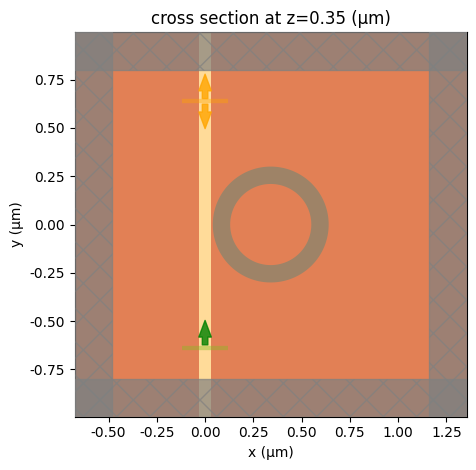

In [ ]:
sim = make_sim(1.48)
sim.plot(z=H / 2)
plt.show()

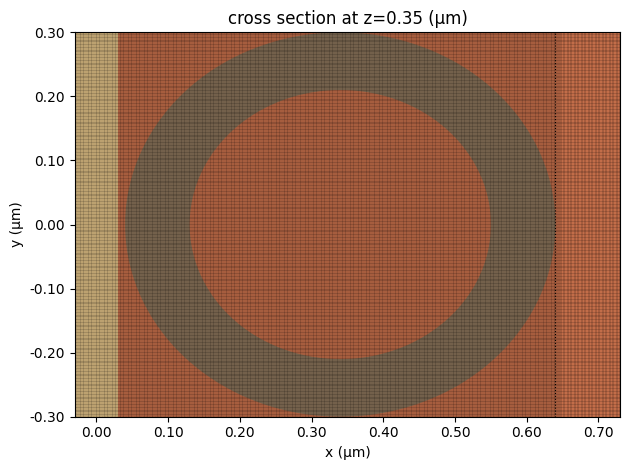

In [ ]:
ax = sim.plot(z=H / 2)
sim.plot_grid(z=H / 2, ax=ax)
ax.set_xlim(-W / 2, W / 2 + g + W1 + L)
ax.set_ylim(-L / 2, L / 2)
ax.set_aspect("auto")
plt.show()

In [ ]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=mode_source.center, size=mode_source.size),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

13:24:09 UTC WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.web.run(...)' or the deprecated    
             'tidy3d.plugins.mode.web.run(...)'.                                

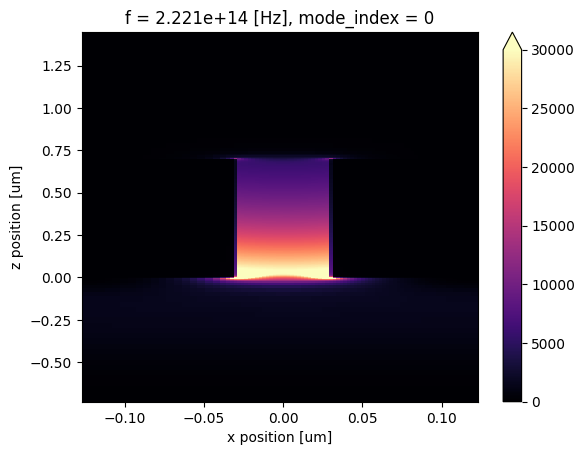

In [ ]:
mode_data.intensity.plot(x="x", y="z", cmap="magma", vmin=0, vmax=3e4)
plt.show()

In [ ]:
!pip install pipx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
!apt install python3.10-venv


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,474 kB of archives.
After this operation, 2,885 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip-whl all 22.0.2+dfsg-1ubuntu0.5 [1,680 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-setuptools-whl all 59.6.0-1.2ubuntu0.22.04.2 [788 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3.10-venv amd64 3.10.12-1~22.04.9 [5,722 B]
Fetched 2,474 kB in 1s (2,306 kB/s)
Selecting previously unselected package python3-pip-whl.
(Reading database ... 126101 files and directories currently installed.)
Pr

In [ ]:
pip install pipx

In [ ]:
!ls -la /content
!mkdir -p ~/.tidy3d
!mv /content/confipu ~/.tidy3d/config



total 24
drwxr-xr-x 1 root root 4096 Apr 30 13:28 .
drwxr-xr-x 1 root root 4096 Apr 30 13:22 ..
drwxr-xr-x 4 root root 4096 Apr 28 13:34 .config
-rw-r--r-- 1 root root   59 Apr 30 13:28 configpu
drwxr-xr-x 2 root root 4096 Apr 30 13:26 data
drwxr-xr-x 1 root root 4096 Apr 28 13:35 sample_data
mv: cannot stat '/content/confipu': No such file or directory


In [ ]:
!ls -la /config


ls: cannot access '/config': No such file or directory


In [ ]:
!cat ~/.tidy3d/config


apikey = "3Ffiqh7B43VxYoaQoDGuIpnHlIuxY1G07uG1GUoRLqtjo6AR"

In [ ]:
# !pipx run tidy3d configure --apikey=3Ffiqh7B43VxYoaQoDGuIpnHlIuxY1G07uG1GUoRLqtjo6AR

In [ ]:
# import os

# # Set your API Key (Replace 'your_api_key_here' with your actual key)
# # os.environ["TIDY3D_API_KEY"] = "3Ffiqh7B43VxYoaQoDGuIpnHlIuxY1G07uG1GUoRLqtjo6AR"
# # web.apikey = os.environ["TIDY3D_API_KEY"]
# web.apikey ="3Ffiqh7B43VxYoaQoDGuIpnHlIuxY1G07uG1GUoRLqtjo6AR"

# # Verify API Key is set
# print(f"API Key Loaded: {web.apikey[:5]}********")


In [ ]:
# print(web.get_credits())
# td.web.monitor_simulations()

In [ ]:
# refractive index values to be simulated
n_phmb_array = np.array([1.51])

# define a simulation batch
sims = {f"n_phmb={n_phmb:.2f}": make_sim(n_phmb) for n_phmb in n_phmb_array}

batch = web.Batch(simulations=sims)

# run the batch
batch_results = batch.run(path_dir="data")

Output()

13:29:42 UTC Started working on Batch containing 1 tasks.

             ERROR: Your simulation is aborted due to insufficient balance. You 
             can reduce the simulation cost with                                
             'https://www.flexcompute.com/tidy3d/learning-center/faq/#how-can-i-
             reduce-the-simulation-cost' or click                               
             'https://tidy3d.simulation.cloud/account?tab=plan' to add more     
             credits.                                                           

13:29:43 UTC Maximum FlexCredit cost: 30.007 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

             Batch complete.

Output()

13:29:44 UTC ERROR: Failed to download the simulation data file from the server.
             Please confirm that the task was successfully run.                 

In [ ]:
for n_phmb in n_phmb_array:
    sim_data = batch_results[f"n_phmb={n_phmb:.2f}"]
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+")
    T = np.abs(amp) ** 2
    plt.plot(ldas, 10 * np.log10(T), label=f"n={n_phmb}")

plt.legend()
plt.xlim(np.min(ldas) , np.max(ldas))
plt.ylim(-35, -3)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission (dB)")
plt.show()

13:29:57 UTC ERROR: Failed to download the simulation data file from the server.
             Please confirm that the task was successfully run.                 

WebError: Failed to download the simulation data file from the server. Please confirm that the task was successfully run.

In [ ]:
sim_data = batch_results["n_phmb=1.51"]
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim_data.plot_field(
    field_monitor_name="field",
    field_name="Hz",
    val="real",
    ax=ax1,
    f=np.min(freqs),
    vmin=-0.3,
    vmax=0.3,
)
sim_data.plot_field(
    field_monitor_name="field", field_name="Hz", val="real", ax=ax2, f=freq0, vmin=-0.3, vmax=0.3
)
plt.show()

13:30:04 UTC ERROR: Failed to download the simulation data file from the server.
             Please confirm that the task was successfully run.                 

WebError: Failed to download the simulation data file from the server. Please confirm that the task was successfully run.